In [1]:
import sys
sys.path.append("..")

#%load_ext autoreload
#%autoreload 1
#%aimport src.datasets.joins
#%aimport src.datasets.loading.statcan

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from src.datasets.loading import statcan
from src.datasets.loading import ookla
from src.datasets import overlays

import statsmodels as sm
# import statsmodels.stats.weightstats
from scipy.stats import lognorm

In [3]:
from src.datasets import joins

In [4]:
popctrs = statcan.boundary('population_centres')

In [5]:
o = joins.hexagons_popctrs_overlay()

/Users/zacharyshand/ookla-statcan-analysis/notebooks/../src/datasets/overlays.py:25: UserWarning: `keep_geom_type=True` in overlay resulted in 418 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  ol = gp.overlay(left, right, how="union")


In [6]:
tiles = ookla.canada_speed_tiles().loc[lambda s:(s.year==2022 ) & (s.conn_type=='fixed')]
tiles = tiles.to_crs(popctrs.crs)

In [69]:
bins = [0,1,2,3,4,5,10,50,100,1000]
(tiles.tests/tiles.devices).value_counts(bins=bins, normalize=True)*100

(-0.001, 1.0]      33.797536
(1.0, 2.0]         24.588664
(2.0, 3.0]         15.166442
(3.0, 4.0]          8.542504
(5.0, 10.0]         8.292594
(4.0, 5.0]          4.982127
(10.0, 50.0]        4.353201
(50.0, 100.0]       0.216883
(100.0, 1000.0]     0.060049
dtype: float64

In [70]:
o_statted = joins.add_simple_stats(o, tiles, 'HEXUID_PCPUID')

In [71]:
o_statted = o_statted.merge(statcan.hexagon_data(), on='HEXuid_HEXidu', how='left')

In [72]:
def breakpoint(value):
    if value == '>75% -  100%':
        return 0.75
    elif value == '>50% - 75%':
        return 0.5
    elif value == '>25% - 50%':
        return 0.25
    elif value == '>0% - 25%':
        return 0.0
    else:
        return 0.0
        
def status(p, isOverEstimated):
    if p > 0.75:
        return 'Good'
    elif isOverEstimated:
        return 'Overestimated'
    elif pd.isna(p):
        return "Unknown"
    else:
        return 'Bad'

o_statted['crtc_label_numerical'] = o_statted.Avail_50_10_Gradient_Dispo.apply(breakpoint)
o_statted['over_estimated_down'] = o_statted['crtc_label_numerical'] > o_statted['p>50Mbps_down']
o_statted['over_estimated_up'] = o_statted['crtc_label_numerical'] > o_statted['p>10Mbps_up']
o_statted['status_code_down'] = o_statted.apply(lambda s:status(s['p>50Mbps_down'], s.over_estimated_down), axis=1)
o_statted['status_code_up'] = o_statted.apply(lambda s:status(s['p>10Mbps_up'], s.over_estimated_up), axis=1)

In [73]:
phh_geo = statcan.phh_geometry()
phh_data = statcan.phh_data()
phh_full = phh_geo.merge(phh_data, on='PHH_ID', validate='1:1')
phh_full = phh_full.loc[lambda s:(s.Pop2016 > 0.0) | (s.TDwell2016_TLog2016 > 0.0) | (s.URDwell2016_RH2016 > 0)]

In [74]:
o_statted = joins.add_phh_pop(o_statted, phh_full, 'HEXUID_PCPUID')

In [75]:
o_statted = o_statted.dropna(subset=['HEXUID_PCPUID'])

In [76]:
o_statted['pop_at_50_down'] = o_statted['Pop2016']*o_statted['p>50Mbps_down']
o_statted['pop_below_50_down'] = o_statted['Pop2016'] - o_statted['pop_at_50_down']
o_statted['pop_at_10_up'] = o_statted['Pop2016']*o_statted['p>10Mbps_up']
o_statted['pop_below_10_up'] = o_statted['Pop2016'] - o_statted['pop_at_10_up']

o_statted['pop_meets_50_10'] = o_statted.apply(lambda s:min(s.pop_at_50_down, s.pop_at_10_up),axis=1)
o_statted['pop_below_50_10'] = o_statted['Pop2016'] - o_statted['pop_meets_50_10']
o_statted['percent_above_50_10'] = o_statted['pop_meets_50_10']/o_statted['Pop2016']
o_statted['status_50_10'] = o_statted.apply(lambda s:status(s['percent_above_50_10'], (s.over_estimated_down | s.over_estimated_up)), axis=1)

In [77]:
o_statted['pop_at_100_down'] = o_statted['Pop2016']*o_statted['p>100Mbps_down']
o_statted['pop_below_100_down'] = o_statted['Pop2016'] - o_statted['pop_at_100_down']
o_statted['pop_at_20_up'] = o_statted['Pop2016']*o_statted['p>20Mbps_up']
o_statted['pop_below_20_up'] = o_statted['Pop2016'] - o_statted['pop_at_20_up']

o_statted['pop_meets_100_20'] = o_statted.apply(lambda s:min(s.pop_at_100_down, s.pop_at_20_up),axis=1)
o_statted['pop_below_100_20'] = o_statted['Pop2016'] - o_statted['pop_meets_100_20']
o_statted['percent_above_100_20'] = o_statted['pop_meets_100_20']/o_statted['Pop2016']
o_statted['status_100_20'] = o_statted.apply(lambda s:status(s['percent_above_100_20'], (s.over_estimated_down | s.over_estimated_up)), axis=1)

In [78]:
o_statted['isRural'] = o_statted['HEXUID_PCPUID'].str.contains('XXXXXX')

In [79]:
o_statted[['pop_at_50_down','pop_below_50_down']].sum()/o_statted['Pop2016'].sum()

pop_at_50_down       0.885232
pop_below_50_down    0.101844
dtype: float64

In [80]:
just_rural = o_statted.dropna(subset=['HEXUID_PCPUID']).loc[lambda s:s.isRural]
just_rural[['pop_at_50_down','pop_below_50_down']].sum()/just_rural.Pop2016.sum()*100

pop_at_50_down       52.770677
pop_below_50_down    40.448846
dtype: float64

In [81]:
pd.DataFrame(just_rural[['pop_at_50_down','pop_below_50_down']].sum()).style.format('{:,.0f}')

In [82]:
o_statted.groupby('isRural')[['pop_at_10_up','pop_below_10_up']].sum()/o_statted['Pop2016'].sum()*100

pop_at_10_up  pop_below_10_up
isRural                               
False       76.680125         4.583244
True         9.266099         8.187125

In [83]:
o_statted.groupby('isRural')[['pop_meets_50_10','pop_below_50_10']].sum().style.format("{:,.0f}")#/o_statted['Pop2016'].sum()*100

In [84]:
o_statted.groupby('isRural')[['pop_meets_100_20','pop_below_100_20']].sum()/o_statted['Pop2016'].sum()*100

pop_meets_100_20  pop_below_100_20
isRural                                    
False           63.703314         17.560055
True             5.223465         12.220850

In [85]:
# Ottawa - Gatineau 
xmin, ymin, xmax, ymax = popctrs.loc[lambda s:s.PCNAME=="Calgary"].buffer(100000).total_bounds
#simple_hex.cx[xmin:xmax, ymin:ymax].to_crs('epsg:4326').plot(column='avg_d_kbps', figsize=(20,20),edgecolor='k', legend=True, vmin=0, vmax=300e3)
o_statted.loc[lambda s:s.Pop2016>0.0].cx[xmin:xmax, ymin:ymax].to_crs('epsg:4326')[[
    'geometry', 'HEXUID_PCPUID',
    'avg_d_kbps', 'std_d_kbps', 'max_d_kbps',
    'avg_u_kbps', 'std_u_kbps', 'max_u_kbps',
    'avg_lat_ms', 
    'tests', 'num_tiles', 
    'Avail_50_10_Gradient_Dispo',
    'p>50Mbps_down', 'p>10Mbps_up',
    'q25_down_kbps','q50_down_kbps', 'q75_down_kbps',
    'SumPop_2016_SommePop', 'Pop2016', 'status_50_10'
]].explore(
    column='status_50_10', missing_kwds={'color':'gray'}, 
    legend=True, vmin=0, vmax=300e3, 
    tooltip=['HEXUID_PCPUID','Pop2016','avg_d_kbps'], popup=True, 
    cmap=['Red','Blue','Orange','Grey'], categorical=True)

In [86]:
def simple_status(s):
    if s['crtc_label_numerical'] < 0.5:
        return "<50/10"
    elif (s.avg_d_kbps > 50000) & (s.avg_u_kbps > 10000):
        return ">50/10"
    else:
        return "Overestimated"
    

In [87]:
o_statted['Average Speed Status'] = o_statted.apply(simple_status, axis=1)

In [88]:
# Ottawa - Gatineau 
xmin, ymin, xmax, ymax = popctrs.loc[lambda s:s.PCNAME=="Edmonton"].buffer(100000).total_bounds
#simple_hex.cx[xmin:xmax, ymin:ymax].to_crs('epsg:4326').plot(column='avg_d_kbps', figsize=(20,20),edgecolor='k', legend=True, vmin=0, vmax=300e3)
o_statted.loc[lambda s:s.Pop2016>0.0].cx[xmin:xmax, ymin:ymax].to_crs('epsg:4326')[[
    'geometry',
    'avg_d_kbps', 'std_d_kbps', 'max_d_kbps',
    'avg_u_kbps', 'std_u_kbps', 'max_u_kbps',
    'tests', 'num_tiles', 
    'Avail_50_10_Gradient_Dispo',
    'Average Speed Status', 'Pop2016'
]].explore(
    column='Average Speed Status', missing_kwds={'color':'gray'}, 
    legend=True, vmin=0, vmax=300e3, 
    tooltip=['avg_d_kbps'], popup=True, 
    cmap=['Red','Blue','Orange','Grey'], categorical=True)

In [89]:
o_statted['tests_per_person'] = o_statted.tests/o_statted.Pop2016
o_statted['tiles_per_person'] = o_statted.num_tiles/o_statted.Pop2016

(1000.0, 25002.6)

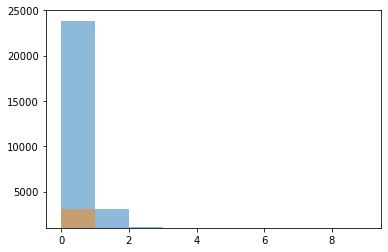

In [90]:
fig, ax = plt.subplots() 
bins = list(range(0,10,1))
ax.hist(o_statted.loc[lambda s:s.Pop2016 > 1.0].loc[lambda s: s.isRural][['tests_per_person']], bins=bins, alpha=0.5)
ax.hist(o_statted.loc[lambda s:s.Pop2016 > 1.0].loc[lambda s:~s.isRural][['tests_per_person']], bins=bins, alpha=0.5)
ax.set_ylim(1000)

[Text(0.5, 0, 'Pop2016'), Text(0, 0.5, 'Tests')]

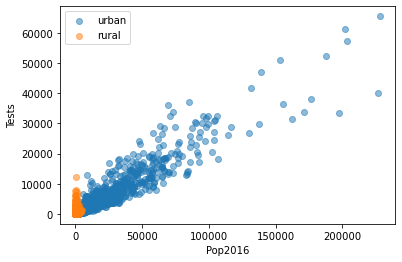

In [91]:
fig, ax = plt.subplots() 
bins = list(range(0,10,1))

y = o_statted.loc[lambda s:s.Pop2016 > 1.0].loc[lambda s:~s.isRural][['tests']]
x = o_statted.loc[lambda s:s.Pop2016 > 1.0].loc[lambda s:~s.isRural][['Pop2016']]
ax.scatter(x, y, alpha=0.5, label='urban')


y = o_statted.loc[lambda s:s.Pop2016 > 1.0].loc[lambda s: s.isRural][['tests']]
x = o_statted.loc[lambda s:s.Pop2016 > 1.0].loc[lambda s: s.isRural][['Pop2016']]
ax.scatter(x, y, alpha=0.5, label="rural")


ax.legend()
ax.set(xlabel="Pop2016", ylabel='Tests')


In [92]:
rural_tests_per_person = o_statted.loc[lambda s:(s.Pop2016 > 1) & (s.isRural)]['tests_per_person'].median()
urban_tests_per_person = o_statted.loc[lambda s:(s.Pop2016 > 1) & (~s.isRural)]['tests_per_person'].median()
print(f"Rural tests per person per tile: {rural_tests_per_person}; Urban tests per person: {urban_tests_per_person}")

Rural tests per person per tile: 0.30444481580747274; Urban tests per person: 0.24665273140039906


In [93]:
f"{o_statted.tests.sum():,.0f}"

'11,040,307'

In [94]:
tiles.head()

quadkey                                           geometry  \
7   302312221203002  POLYGON ((7697916.622 1255685.099, 7698333.528...   
27  302230331100310  POLYGON ((7037604.587 884757.824, 7038053.530 ...   
28  302230331100310  POLYGON ((7037604.587 884757.824, 7038053.530 ...   
29  302230331100310  POLYGON ((7037604.587 884757.824, 7038053.530 ...   
48  302302300230211  POLYGON ((7340610.090 1211012.936, 7341030.855...   

    avg_d_kbps  avg_u_kbps  avg_lat_ms  tests  devices conn_type  year  \
7        67907        8983          12      6        3     fixed  2022   
27        9972        3613           3      1        1     fixed  2022   
28       75419       69597           3     15        5     fixed  2022   
29       58606       48144           5     27        6     fixed  2022   
48       40022       21540          14      5        1     fixed  2022   

    quarter  
7         2  
27        1  
28        2  
29        3  
48        1

<AxesSubplot:xlabel='avg_d_kbps', ylabel='q75_down_kbps'>

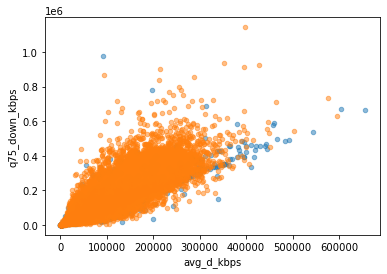

In [95]:
## question: do I think the hexes with low statistics are being misrepresented in statisics values
ax = o_statted.loc[lambda s:s.num_tiles < 3].plot.scatter('avg_d_kbps','q75_down_kbps', alpha=0.5)
o_statted.loc[lambda s:s.num_tiles >= 3].plot.scatter('avg_d_kbps','q75_down_kbps', ax=ax, color='C1', alpha=0.5)

In [96]:
# examine some distributions 
tiles_sample_join = o_statted[['geometry','HEXUID_PCPUID','q25_down_kbps','q50_down_kbps','q75_down_kbps']].sjoin(tiles)

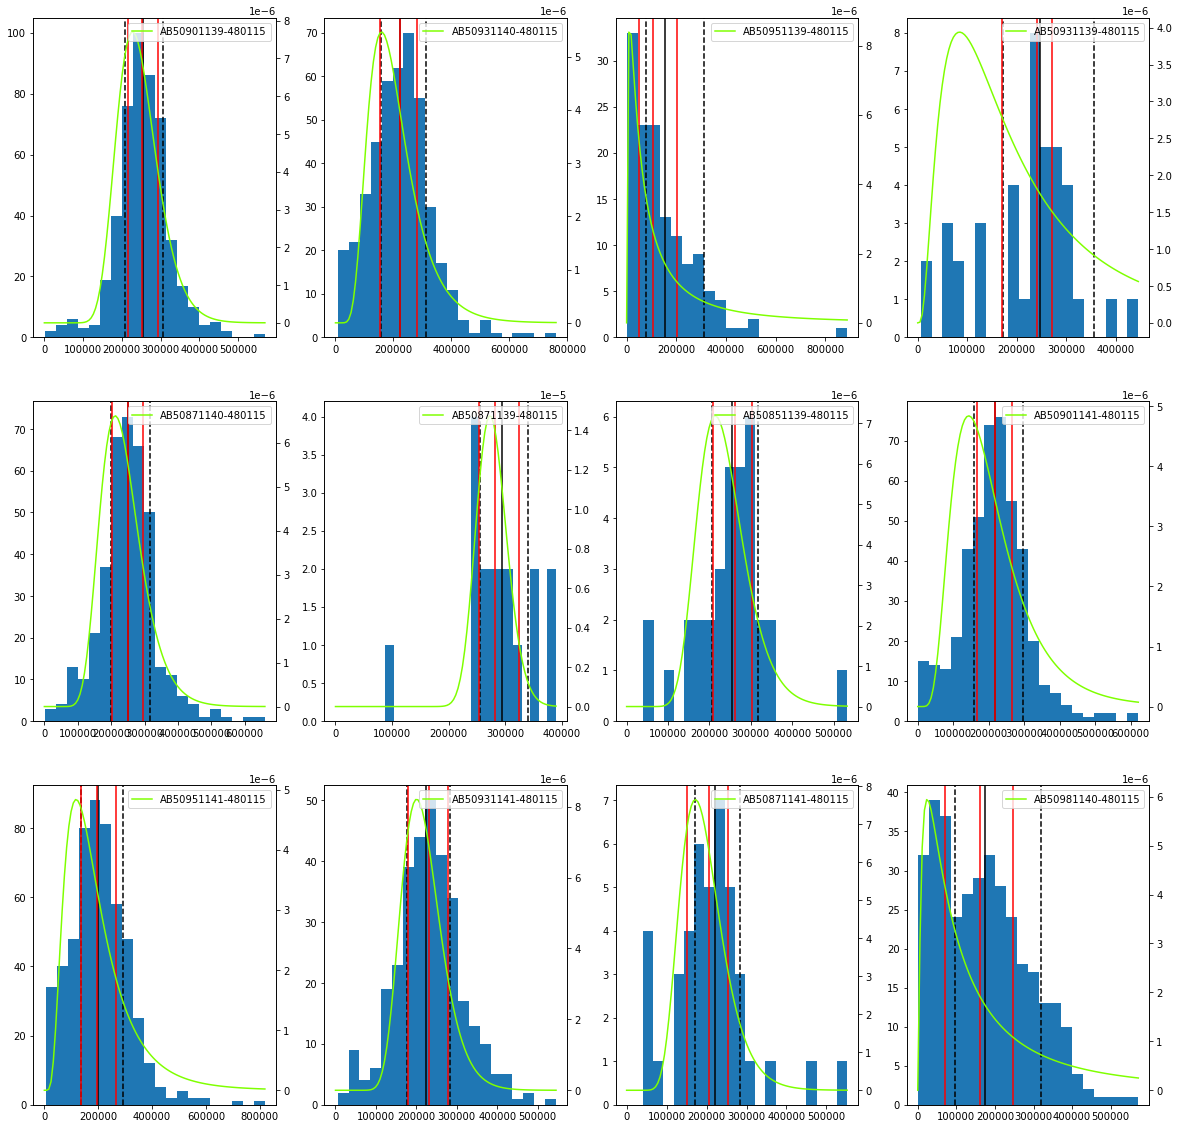

In [97]:
sample_ids = tiles_sample_join.loc[tiles_sample_join.HEXUID_PCPUID.str.contains("-480115"), 'HEXUID_PCPUID'].unique()#.nunique(12)#
#axs = tiles_sample_join.loc[lambda s:s.HEXUID_PCPUID.isin(sample_ids)][['avg_d_kbps','HEXUID_PCPUID']].hist(by='HEXUID_PCPUID', figsize=(20,20))
fig, axs = plt.subplots(3,4, figsize=(20,20))
for ax, hex_id in zip(axs.flatten(), sample_ids):
    a,b,c = o_statted.loc[lambda s:s.HEXUID_PCPUID==hex_id, ['q25_down_kbps','q50_down_kbps','q75_down_kbps']].iloc[0]
    ax.hist(tiles_sample_join.loc[lambda s:s.HEXUID_PCPUID == hex_id, 'avg_d_kbps'], bins=20)

    qq25 = np.percentile(tiles_sample_join.loc[lambda s:s.HEXUID_PCPUID == hex_id, 'avg_d_kbps'], 25)
    qq50 = np.percentile(tiles_sample_join.loc[lambda s:s.HEXUID_PCPUID == hex_id, 'avg_d_kbps'], 50)
    qq75 = np.percentile(tiles_sample_join.loc[lambda s:s.HEXUID_PCPUID == hex_id, 'avg_d_kbps'], 75)

    ax.axvline(a, color='k', ls='dashed')
    ax.axvline(b, color='k')
    ax.axvline(c, color='k', ls='dashed')

    ax.axvline(qq25, color='red')
    ax.axvline(qq50, color='red')
    ax.axvline(qq75, color='red')

    x, s = o_statted.loc[lambda s:s.HEXUID_PCPUID==hex_id, ['avg_d_kbps','std_d_kbps']].iloc[0]
    # ax.axvline(x, color='r', ls='solid')
    # ax.axvline(x+s, color='r', ls='dotted')
    # ax.axvline(x-s, color='r', ls='dotted')
    logx, logv = o_statted.loc[lambda s:s.HEXUID_PCPUID==hex_id, ['logmean_d_kbps','logvar_d_kbps']].iloc[0]
    rv = lognorm(s=logv, scale=np.exp(logx))
    top = o_statted.loc[lambda s:s.HEXUID_PCPUID==hex_id, ['max_d_kbps']].iloc[0][0]
    xs = np.linspace(0, max(100000,top), 100)
    ax2 = ax.twinx()
    ax2.plot(xs, rv.pdf(xs),color='chartreuse', label=hex_id)
    ax2.legend(loc='upper right')

    # ax.set_xscale('log')


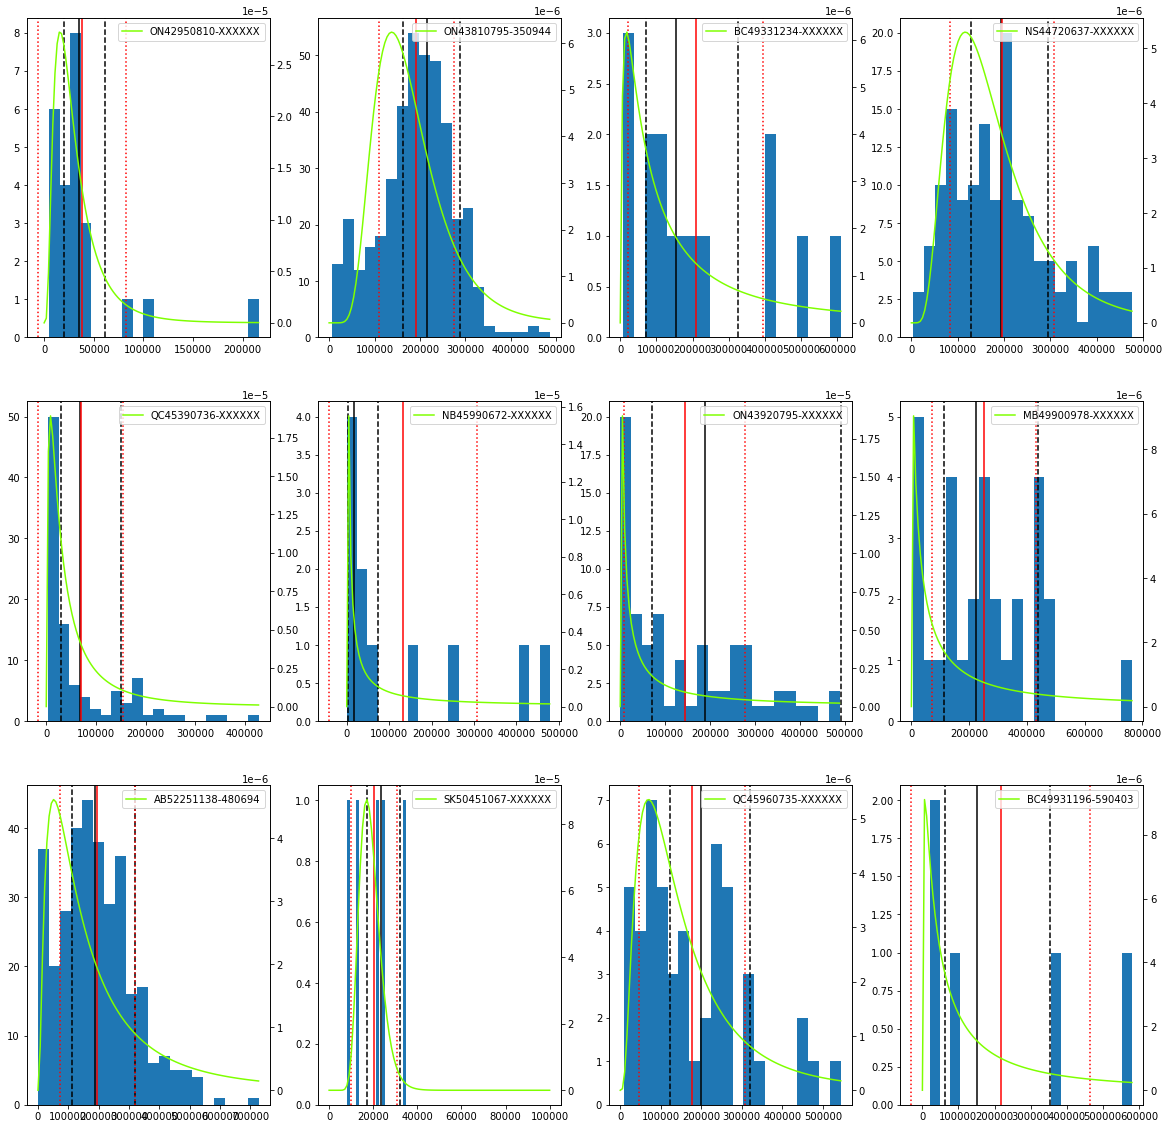

In [98]:
sample_ids = tiles_sample_join.sample(12, random_state=3).HEXUID_PCPUID
#axs = tiles_sample_join.loc[lambda s:s.HEXUID_PCPUID.isin(sample_ids)][['avg_d_kbps','HEXUID_PCPUID']].hist(by='HEXUID_PCPUID', figsize=(20,20))
fig, axs = plt.subplots(3,4, figsize=(20,20))
for ax, hex_id in zip(axs.flatten(), sample_ids.values):
    a,b,c = o_statted.loc[lambda s:s.HEXUID_PCPUID==hex_id, ['q25_down_kbps','q50_down_kbps','q75_down_kbps']].iloc[0]
    ax.hist(tiles_sample_join.loc[lambda s:s.HEXUID_PCPUID == hex_id, 'avg_d_kbps'], bins=20)
    ax.axvline(a, color='k', ls='dashed')
    ax.axvline(b, color='k')
    ax.axvline(c, color='k', ls='dashed')
    x, s = o_statted.loc[lambda s:s.HEXUID_PCPUID==hex_id, ['avg_d_kbps','std_d_kbps']].iloc[0]
    ax.axvline(x, color='r', ls='solid')
    ax.axvline(x+s, color='r', ls='dotted')
    ax.axvline(x-s, color='r', ls='dotted')
    logx, logv = o_statted.loc[lambda s:s.HEXUID_PCPUID==hex_id, ['logmean_d_kbps','logvar_d_kbps']].iloc[0]
    rv = lognorm(s=logv, scale=np.exp(logx))
    top = o_statted.loc[lambda s:s.HEXUID_PCPUID==hex_id, ['max_d_kbps']].iloc[0][0]
    xs = np.linspace(0, max(100000,top), 100)
    ax2 = ax.twinx()
    ax2.plot(xs, rv.pdf(xs),color='chartreuse', label=hex_id)
    ax2.legend(loc='upper right')

    # ax.set_xscale('log')


array([[<AxesSubplot:title={'center':'tests'}>]], dtype=object)

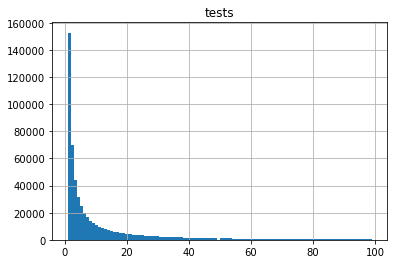

In [99]:
tiles[tiles.tests<100][['tests']].hist(bins=100)

In [100]:
tilegrps = tiles.groupby('quadkey')
tile_d_stats = tilegrps['avg_d_kbps'].agg(['mean','std','max','min','count'])

In [101]:
tile_d_stats.describe().style.format("{:,.0f}")

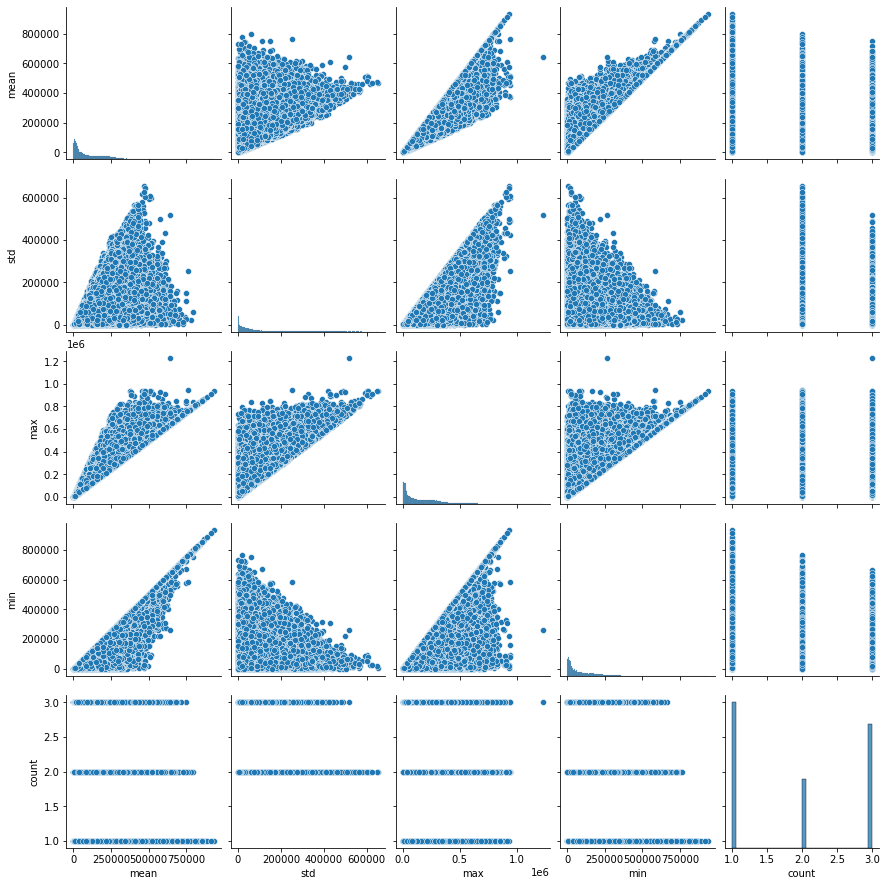

In [102]:
sns.pairplot(tile_d_stats)

In [103]:
## Check a Variance
rv = lognorm(scale=4, s=1.5)
xs = np.linspace(0,20, 100)
yys = rv.rvs(200)
fit_params = lognorm.fit(yys)

print(fit_params)
print(f"True mean: {rv.mean()}, True std: {rv.std()} ")
print(f"logmean: {np.mean(np.log(yys))}; logstd: {np.std(np.log(yys))}")

# fig, ax = plt.subplots()
# ax.plot(xs, rv.pdf(xs))
# ax.hist(yys, density=True, bins=100);
# ax.plot(xs, lognorm(*fit_params).pdf(xs))



(1.5689071327087225, 0.05999329387082851, 3.4639162127461622)
True mean: 12.320867395672126, True std: 35.895268872465806 
logmean: 1.2946045385795764; logstd: 1.4957067897695866


In [104]:
sample_sizes = [10, 5, 12, 2, 30, 50, 5, 11, 1, 3, 4, 1, 2, 22] #[50] * 1000 
sample_sizes = sample_sizes #+ sample_sizes + sample_sizes
random_variates = [rv.rvs(size=size) for size in sample_sizes]
sample_means = [np.mean(s) for s in random_variates]
sample_stds = [np.std(s) for s in random_variates]
sample_logmeans = [np.mean(np.log(s)) for s in random_variates]
sample_logstd = [np.std(np.log(s)) for s in random_variates]
sample_table = pd.DataFrame(data = np.transpose([sample_sizes, sample_means, sample_stds, sample_logmeans, sample_logstd]), columns=['n','avg','std', 'logmean','logstd'])
#sample_table['std_adj'] = sample_table['std'] / np.sqrt(sample_table['n'])
sample_table;

In [105]:
wmeans = sm.stats.weightstats.DescrStatsW(sample_table['logmean'], np.sqrt(sample_table['n']))
wmeans.mean, wmeans.std, wmeans.std*np.mean(np.sqrt(sample_table['n']))

(1.2896528429495535, 0.48440310295859207, 1.3914246307496136)

In [106]:
sample_fit_params = lognorm.fit(sample_means)
sample_fit_params 

(0.4439724846260882, -3.3876305800029076, 9.282321432457461)

In [107]:
18.8/np.sqrt(50), 1.45/np.sqrt(50)

(2.6587214972614186, 0.20506096654409878)

In [108]:
desc = sample_table[['n','avg', 'logmean']].describe()
desc

n        avg    logmean
count  14.000000  14.000000  14.000000
mean   11.285714   6.836614   1.138406
std    14.007847   4.690276   0.713457
min     1.000000   0.395332  -0.928029
25%     2.250000   3.755470   1.083012
50%     5.000000   5.975349   1.221815
75%    11.750000   7.795552   1.484827
max    50.000000  15.438895   2.067978

log mean mean 1.1384064083170307; scale = 3.1217895412846617
0.7134571899170293 11.285714285714286
log mean std 2.0410353220339474; s = 2.396803579344195


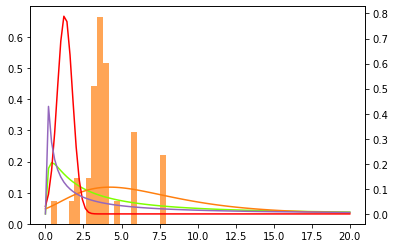

In [109]:
#ax = sample_table[['avg']].hist()[0,0]
fig, ax = plt.subplots()
ax.hist(np.exp(wmeans.asrepeats()), bins=20, alpha=0.7, color='C1', density=True)
ax2 = ax.twinx()
#ax2.hist(np.exp(wmeans.asrepeats()), bins=20, alpha=0.7, color='C1', density=True)
ax2.plot(xs, rv.pdf(xs), color='chartreuse')
ax2.plot(xs, lognorm(*sample_fit_params).pdf(xs), color='C1')
ax2.plot(xs, lognorm(*lognorm.fit(wmeans.asrepeats())).pdf(xs), color='red')

scale = np.exp(desc.loc['mean','logmean'])
print(f"log mean mean {desc.loc['mean','logmean']}; scale = {scale}")

print(desc.loc['std','logmean'], desc.loc['mean','n'])
s = desc.loc['std','logmean']*np.sqrt(desc.loc['mean','n'])
print(f"log mean std {np.exp(desc.loc['std','logmean'])}; s = {s}")

ax2.plot(xs, lognorm(s=s, scale=scale).pdf(xs), color='C4')


In [110]:
import gc
gc.collect()

182702

In [111]:
from math import sqrt, log
def relative_var(sigma, sigma_central, c, t):
    return sigma/sigma_central/sqrt(c*t)

s = log(50)
c = 25
s_c = s/c

rv = relative_var(s, s_c, c,1.0)
(s, s_c, c, rv)

(3.912023005428146, 0.15648092021712584, 25, 5.0)

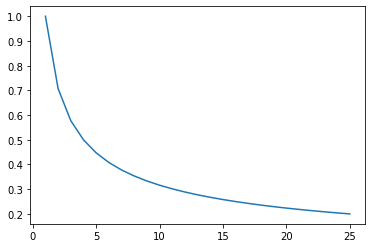

In [112]:
ns = np.linspace(1,25,25)
sigma = 1.0
sigma_mean = sigma/np.sqrt(ns)
plt.plot(ns, sigma_mean)